In [1]:
from biom import load_table
import numpy as np
import pandas as pd
import seaborn as sns
from patsy import dmatrix
import os
%matplotlib inline

In [2]:
!ls ../data

File_1_TaoDing_microbiome.biom
File_2_TaoDing_Microbiome_taxonomy.tsv
File_3_FerretMicrobiomeMetadata.xlxs.xlsx
~$File_3_FerretMicrobiomeMetadata.xlxs.xlsx


In [3]:
fname = '../data/File_1_TaoDing_microbiome.biom'
table = load_table(fname)

In [4]:
fname = 'File_3_FerretMicrobiomeMetadata.xlxs.xlsx'
fname = os.path.join('../data/', fname)
metadata = pd.read_excel(fname)

# Handle batch metadata

In [5]:
len(list(metadata.groupby('sampleID')))

811

In [6]:
id_counts = metadata.sampleID.value_counts()
batches = id_counts.loc[id_counts>1].index

In [7]:
batch_metadata = metadata.set_index('sampleID').loc[batches]

In [8]:
batch_metadata = batch_metadata.reset_index()

In [9]:
len(batch_metadata.sampleID.value_counts())

216

Filter and match

In [10]:
batch_filter = lambda v, i, m: i in set(batch_metadata.SeqID)
read_filter = lambda v, i, m: v.sum()>100
obs_filter = lambda v, i, m: (v>0).sum()>5

table.filter(batch_filter, axis='sample')
table.filter(read_filter, axis='sample')
table.filter(obs_filter, axis='observation')

tab = table.to_dataframe().T.to_dense()
tab = tab.loc[batch_metadata.SeqID].dropna()
batch_metadata = batch_metadata.set_index('SeqID')
batch_metadata = batch_metadata.loc[tab.index]
batch_metadata = batch_metadata.reset_index()

/Users/jmorton/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/biom/table.py:4068: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return constructor(mat, index=index, columns=columns)
/Users/jmorton/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/pandas/core/sparse/frame.py:257: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  sparse_index=BlockIndex(N, blocs, blens),
/Users/jmorton/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/pandas/core/generic.py:4583: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a S

Prepare for stan

In [11]:
sample_ids = batch_metadata.sampleID.unique()
id_lookup = pd.Series(np.arange(len(sample_ids)), index=sample_ids)
per_sample_ids = batch_metadata.sampleID.apply(lambda x: id_lookup[x]).values + 1

run_ids = batch_metadata.runID.unique()
id_lookup = pd.Series(np.arange(len(run_ids)), index=run_ids)
per_sample_batch_ids = batch_metadata.runID.apply(lambda x: id_lookup[x]).values + 1

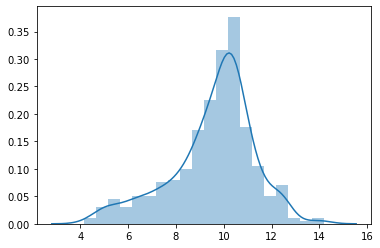

In [12]:
sns.distplot(np.log(tab.sum(axis=1)).values)

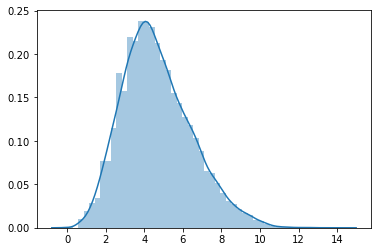

In [13]:
t = tab.values.ravel()
sns.distplot(np.log(t[t>0]))

In [14]:
per_sample_ids

array([  1,   1,   1,   1,   2,   2,   2,   3,   3,   3,   4,   4,   5,
         5,   5,   6,   6,   7,   7,   7,   8,   8,   8,   9,   9,  10,
        10,  10,  11,  11,  11,  12,  12,  13,  13,  14,  15,  16,  16,
        16,  17,  17,  18,  19,  19,  20,  20,  20,  21,  21,  22,  22,
        22,  23,  23,  23,  24,  24,  24,  25,  25,  26,  26,  26,  27,
        27,  27,  28,  28,  29,  29,  30,  30,  31,  31,  32,  32,  33,
        34,  34,  35,  36,  37,  38,  38,  39,  39,  40,  40,  41,  41,
        42,  42,  43,  43,  44,  44,  45,  45,  46,  46,  47,  47,  48,
        48,  49,  49,  50,  51,  51,  52,  53,  53,  54,  54,  55,  55,
        56,  57,  58,  58,  59,  59,  60,  60,  61,  61,  62,  62,  63,
        63,  64,  64,  65,  65,  66,  66,  67,  67,  68,  68,  69,  69,
        70,  70,  71,  72,  73,  73,  74,  74,  75,  76,  77,  77,  78,
        78,  79,  79,  80,  80,  81,  81,  82,  82,  83,  84,  84,  85,
        85,  86,  86,  87,  87,  88,  88,  89,  90,  90,  91,  9

# Actual modeling

We will adopt a Negative Binomial linear mixed effects models for this context.

Our model is given as follows

$\lambda_{ik} = \gamma_k + s_i$

$y_{ik} \sim NB(\lambda_{ik})$

Where s_i encodes sample distribution i and $\gamma_k$ corresponds to the batch specific bias and $\alpha_l$ corresponds to the random intercept for each ferret.

See this document for more details on linear mixed models
http://jakewestfall.org/misc/SorensenEtAl.pdf

In [19]:
import pystan

code = open('../models/nb_batch.stan', 'r').read()
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c0f365d1d9917f782a76dec78a50e331 NOW.


# Run Hamiltonian Monte Carlo

In [ ]:
dat = {
    'M' : batch_metadata.shape[0],
    'R' : len(set(per_sample_batch_ids)),
    'D' : table.shape[0],
    'S' : len(set(per_sample_ids)),    
    'depth' : np.log(tab.sum(axis=1)).values,
    'samp_ids' : per_sample_ids,
    'batch_ids' : per_sample_batch_ids,
    'y' : tab.values.astype(np.int)
}

fit = sm.sampling(data=dat, iter=1000, chains=4)
res =  fit.extract(permuted=True)

In [ ]:
import pickle

pickle.dump({'dat': dat, 'fit': fit, 'res': res}, open('fit.pickle', 'wb'))